In [3]:
import warnings
warnings.filterwarnings('ignore')
from demo import Hand

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.multiarray failed to import

In [3]:
import os, sys
import pandas as pd
import json
import subprocess
from io import  StringIO, BytesIO
from PIL import Image
from wand.image import Image as WImage
from wand.drawing import Drawing
import base64
from wand.color import Color
import random

In [4]:
from PIL import ImageFont, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

In [5]:
import re
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [6]:
#from essential_generators import DocumentGenerator
from textwrap import TextWrapper
#gen = DocumentGenerator()
from random import sample
from nltk.corpus import words

In [7]:
#Build / load JSON data about image
#Isolate regions in image
#Choose a text region to replace
# - Replace process
#    - Generate block of text string
#    - Insert in image
#    - Save image to new path.
# - Update JSON data with new label id for block
# - Verify correct mapping for data -> Using other Notebook
#Train model on new data

# process with wand (remove bg and skew/scale)

In [8]:
hand = Hand()

From /usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
From /home/appuser/act3_detectron/handwriting-synthesis/rnn.py:195: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
From /usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/ops/rnn.py:626: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
From /home/appuser/act3_detectron/handwriting-synthesis/rnn_cell.py:81: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:


Tensor("cond/rnn_2/Cast_2:0", shape=(?,), dtype=int32)
Tensor("cond/rnn_2/while/Cast_2:0", shape=(?,), dtype=int32)
Tensor("cond/rnn_4/Cast_2:0", shape=(?,), dtype=int32)
Tensor("cond/rnn_4/while/Cast_2:0", shape=(?,), dtype=int32)


From /usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [9]:
white = Color('rgba(255,255,255,1)')
black = Color('rgba(0,0,0,1)')
    
def apply_image_processing(image):
    """
    Applies a series of image processing steps
    """
    clone = image.clone()
    clone.format="png"
    clone.trim(white, fuzz=0)
    clone.transform_colorspace('rgb')
    clone.border(white, 2, 2)
    clone.reset_coords()
    return clone

def apply_border_line(image, maxWidth, isCroppingTop):
    clone = image.clone()
    clone = WImage(width=maxWidth, height=clone.height)
    clone.composite_channel('default_channels', image, 'over', 0, 0)
    clone.border(white, 0, 2)
    clone.border(black, 0, 1)
    if isCroppingTop:
        clone.crop(width=clone.width, height=clone.height-2, gravity='south')
    return clone

def encoding_to_image(base64_string):
    """
    Converts a base64 encoded image to a PIL Image
    """
    imgdata = base64.b64decode(base64_string)
    return Image.open(BytesIO(imgdata))

In [10]:
import timeit
from multiprocessing import Process

In [11]:
def svg_string_to_wand(svgString):
    return WImage(file=BytesIO(str.encode(svgString)), format='svg')


def generate_svg_script(
    line, 
    filename='./img/test.svg',
    bias = 0.85,
    style = 4,
    stroke_color = 'black',
    stroke_width = 1
):
    print(line)
    svg = hand.write(
        filename=filename,
        lines=[line],
        biases=[bias],
        styles=[style],
        stroke_colors=[stroke_color],
        stroke_widths=[stroke_width],
        save=False
    )
    img = svg_string_to_wand(svg.tostring())
    return img


def generate_paragraph(numWords=80, sentenceLimit=5, wrapLimit=75):
    paragraph = ' '.join(sample(words.words(), numWords))
    wrap = TextWrapper(wrapLimit, break_long_words=True)
    return wrap.wrap(paragraph)[:sentenceLimit]


def generate_script(line, style, legibility):
    svgScript = generate_svg_script(line, style=style, bias=legibility)
    image = apply_image_processing(svgScript)
    return image


def write_paragraph(
    paragraph=None, 
    style = None,
    legibility = None, 
    isBorderLined=False
   ):
    if not paragraph:
        paragraph = generate_paragraph(numWords=50, sentenceLimit=2, wrapLimit=75)
        #print(".\n".join(paragraph))
    if not style:
        style =  random.randint(0,9)
    if not legibility:
        legibility = round(random.uniform(0.85, 1), 2)
        
    lineImages = []
    textLines = []
    maxWidth = 0
    
    print("Style: {0}, Legibility: {1}".format(style, legibility))
    
    for line in paragraph:
        image = generate_script(line, style=style, legibility=legibility)
        lineImages.append(image)
        if image.width > maxWidth:
            maxWidth = image.width
            
    if isBorderLined:
        borderLinedImages = []
        for (i, lineImage) in enumerate(lineImages):
            isCroppingTop = (i != 0) and (len(lineImages) > 1)
            borderLinedImages.append(apply_border_line(lineImage, maxWidth, isCroppingTop))
        lineImages = borderLinedImages
        
    paragraphImage = lineImages[0]
    for additionalLine in lineImages[1:]:
        img = WImage(width=max(paragraphImage.width, additionalLine.width), height=paragraphImage.height+additionalLine.height)
        img.composite_channel('default_channels', paragraphImage, 'over', 0, 0)
        img.composite_channel('default_channels', additionalLine, 'over', 0, paragraphImage.height )
        paragraphImage = img
        
    if isBorderLined:
        paragraphImage.border(white, 0, 5)
    return paragraphImage

In [ ]:
paragraph = generate_paragraph(numWords=50, sentenceLimit=1, wrapLimit=75)
#print(".\n".join(paragraph))
#paragraphImage = write_paragraph(paragraph, isBorderLined=True)
#paragraphImage
print(timeit.timeit(write_paragraph, number=2))

Style: 7, Legibility: 0.95
contrasty procuratorship resuit unstressedly unspiteful Yerava cachinnation


In [241]:
#resized = paragraphImage.clone()

In [190]:
#Load JSON config for pdfs

In [191]:
#pdfs = '/home/appuser/pdfs/publaynet'
basedir = '/home/appuser/act3_detectron'
pdfs = '/home/appuser/act3_detectron/examples'
jsonFiles = [pos_json for pos_json in os.listdir(pdfs) if pos_json.endswith('.json')]
jpgFiles = [pos_json for pos_json in os.listdir(pdfs) if pos_json.endswith('.jpg')]

In [192]:
with open(os.path.join(pdfs, jsonFiles[0])) as f:
    samples = json.load(f)

In [193]:
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

In [194]:
#Load an image, 
#Select a bounding box.
#Create a new image and white out bounding box.

In [196]:
# Define color code
colors = {'title': (255, 0, 0),
          'text': (0, 255, 0),
          'figure': (0, 0, 255),
          'table': (255, 255, 0),
          'list': (0, 255, 255)}

def markup(image, annotations):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw segmentation
        draw.polygon(annotation['segmentation'][0],
                     fill=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (64,))
        # Draw bbox
        draw.rectangle(
            (annotation['bbox'][0],
             annotation['bbox'][1],
             annotation['bbox'][0] + annotation['bbox'][2],
             annotation['bbox'][1] + annotation['bbox'][3]),
            outline=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (255,),
            width=2
        )
        # Draw label
        w, h = draw.textsize(text=samples['categories'][annotation['category_id'] - 1]['name'],
                             font=font)
        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
    return np.array(image)

In [200]:
key = list(images.keys())[2]
image = images[key]

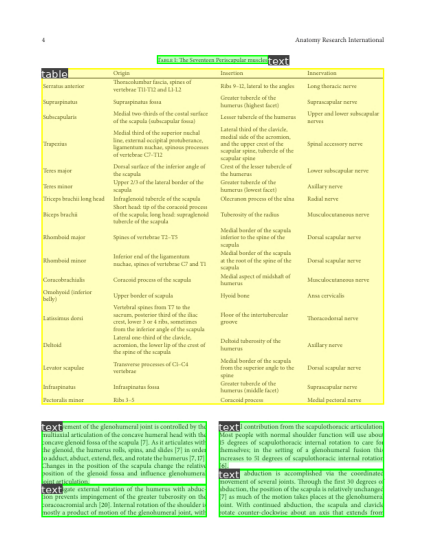

In [201]:
font = ImageFont.truetype("examples/DejaVuSans.ttf", 15)
fig=plt.figure(figsize=(16, 100)) 
with Image.open(os.path.join(basedir, image['file_name'])) as img:
    ax = plt.subplot(len(images) / 2, 2, 1) #index instead of 1
    ax.imshow(markup(img, image['annotations']))
    ax.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
lineHeight = 11.625 #pixels per text line without border

In [280]:
def whiteout_boundingbox(image, bbox):
    with Drawing() as draw:
        #draw.stroke_color = Color('#000')
        draw.fill_color = Color('#fff')
        draw.rectangle(left=bbox[0], top=bbox[1], width=bbox[2], height=bbox[3])
        draw.draw(image)
    return image

def impose_image(imageBackground, imageForeground, bbox):
    img = WImage(width=imageBackground.width, height=imageBackground.height)
    img.composite_channel('default_channels', imageBackground, 'over', 0, 0)
    img.composite_channel('default_channels', imageForeground, 'over', int(bbox[0]), int(bbox[1]))
    return img

def resize_paragraph_fit_bbox(paragraphImage, boundingBox):
    resized = paragraphImage.clone()
    resized.transform(resize='{0}x{1}'.format(boundingBox[2], boundingBox[3]))
    return resized
    

imagePath = os.path.join(basedir, image['file_name'])
boundingBox = image['annotations'][3]['bbox']

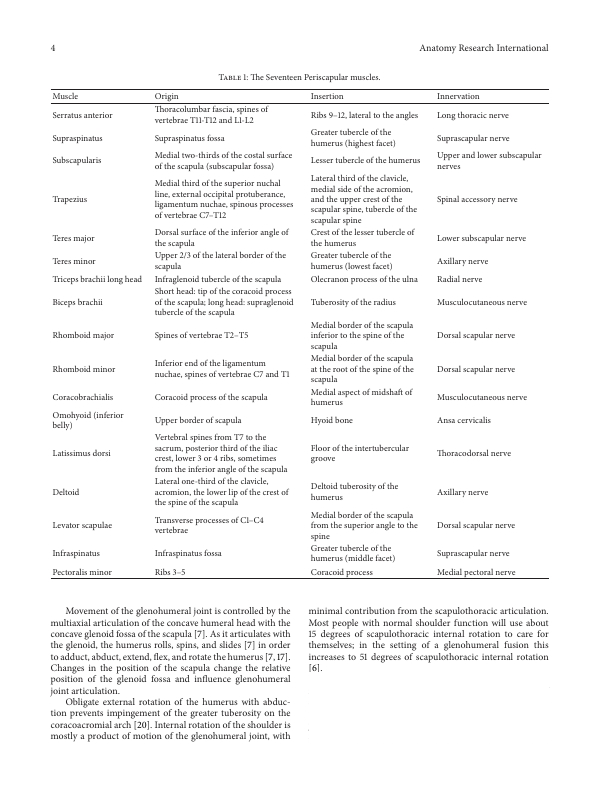

In [281]:
bgImage = WImage(filename=imagePath)
imageBackground = whiteout_boundingbox(bgImage, boundingBox)

whiteout_boundingbox(imageBackground, boundingBox)

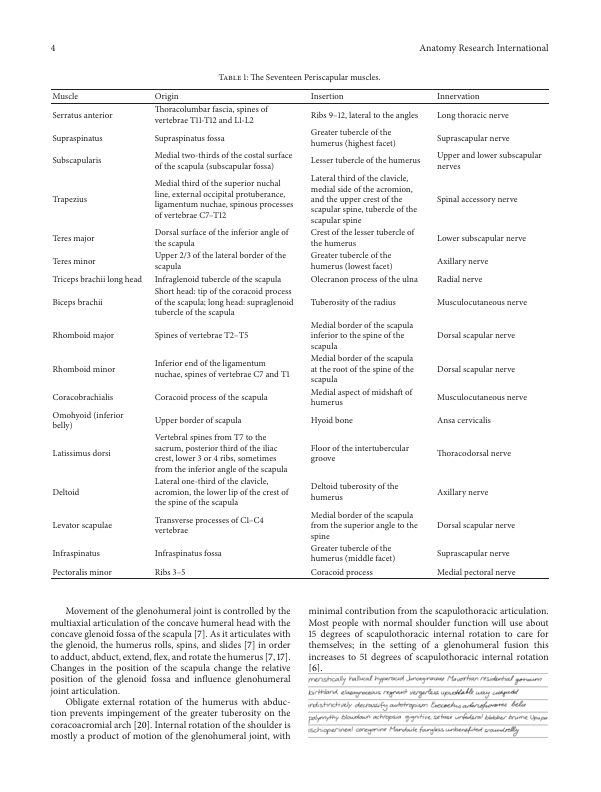

In [282]:
resized = resize_paragraph_fit_bbox(paragraphImage, boundingBox)
forgroundImage = resized
newImage = impose_image(imageBackground, forgroundImage, boundingBox)
newImage